In [1604]:
# portfolio expected return function

In [1605]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def mean_portfolio(weights, *dataopt):
    """Calculate portfolio return"""
    mean_returns = dataopt[0]  # This is the array of expected returns for each asset
    portfolio_return = mean_returns.dot(weights)
    return portfolio_return

In [1606]:
#portfolio standard deviation function with *dataopt will be define in portfolio optimization containing pass through input for optimized

In [1607]:
def std_portfolio(weights, *dataopt):
    """Calculate portfolio volatility (standard deviation)"""
    annualized_returns = dataopt[0]
    # Compute correlation matrix
    correlation_matrix = dataopt[1] 

    # Compute standard deviation (volatility)
    individual_volatility = dataopt[2]

    # Convert to diagonal matrix
    D = np.diag(individual_volatility)

    # Compute covariance matrix
    cov_annualized_returns = np.dot(D, np.dot(correlation_matrix, D)) 
    
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annualized_returns, weights)))

    return portfolio_volatility

In [1608]:
#sharpe ratio function calculation 

In [1609]:
def sharpe_ratio(weights, *dataopt):
    """Calculate Sharpe Ratio"""
    mean_returns = dataopt[0]  # Expected annual returns (array)
    correlation_matrix = dataopt[1]  # Correlation matrix of asset returns
    individual_volatility = dataopt[2]  # Standard deviation (volatility) of each asset

    # Calculate portfolio return
    portfolio_return = np.dot(weights, mean_returns)

    # Convert individual volatilities to a diagonal matrix
    D = np.diag(individual_volatility)

    # Compute covariance matrix using correlation and standard deviations
    cov_annualized_returns = np.dot(D, np.dot(correlation_matrix, D))   # Annualized covariance

    # Compute portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annualized_returns, weights)))

    # Compute Sharpe Ratio
    sharpe = portfolio_return / portfolio_volatility
    return sharpe  # No negation since maximization is handled separately

In [1610]:
#Portfolio main function that will use the function above, this will convert monthly returns into annualized and perform optmization based on sharpe ratio function

In [1611]:
def portfolio_optimization(monthly_returns, stock, last_month_volatility):
    """Optimize portfolio using Sharpe Ratio maximization"""

    
    # Annualized returns
    annualized_returns = monthly_returns.iloc[-1]

    print(annualized_returns)
    # Annualized covariance matrix
    volatility = last_month_volatility
    cor_returns = monthly_returns.corr()
    
    # Prepare optimization inputs
    dataopt = (annualized_returns, cor_returns, volatility)
    num_assets = len(annualized_returns)
    
    # Initial equal weights
    initial_weights = np.ones(num_assets) / num_assets
    
    # Bounds (weights between 0 and 1 for long-only portfolios)
    bounds = [(0.05, 1) for _ in range(num_assets)]
    
    # Constraint: Sum of weights must be 1
    constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Portfolio weights must sum to 1

    ]

    
    # Perform optimization
    result = minimize(
        fun=lambda x, *dataopt: -sharpe_ratio(x, *dataopt),  # Negate return for maximization
        x0=initial_weights,
        args=dataopt,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    storeoptimal_weights = dict(zip(stock, result.x))  # Assuming 'stocks' contains your stock names

    # Convert to DataFrame
    storeweights_df = pd.DataFrame.from_dict(
        storeoptimal_weights, 
        orient='index', 
        columns=['Optimal Weight']
    )
    
    optimal_weights = dict(zip(stock, result.x))
    print("Optimal Portfolio Allocation max SR")
    for asset, weight in optimal_weights.items():
        print(f"{asset}: {weight:.2%}")  # Display as percentage with 2 decimal places
    
    # Portfolio metrics
    portfolio_return = mean_portfolio(result.x, *dataopt)
    portfolio_volatility = std_portfolio(result.x, *dataopt)
    sharpe = portfolio_return / portfolio_volatility
    
    print(f"\nExpected Annual Return: {portfolio_return:.2%}")
    print(f"Annual Volatility: {portfolio_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")

    return sharpe, storeweights_df # Return optimal allocation

    
    # to use just write (optimal_weights = portfolio_optimization(sample_data))
    # sample_data is monthly return data


In [1612]:
# this is data adjustment function along with market cap pick and table transformation 

In [1613]:
def get_top10_by_market_cap(cluster_df): # Defining number of stock in cluster 
    return (
        cluster_df.sort_values('Company Market Cap', ascending=False)
        .head(5)# input
        .reset_index(drop=True)
    )

In [1614]:
import pandas as pd

# Function to pivot and replace NaN with 0
def pivot_and_fill(df, value_column):
    """Pivot the DataFrame and replace NaN with 0"""
    return df.pivot_table(
        index='Date',
        columns='Stock',
        values=value_column,
        aggfunc='first'
    ).fillna(0)  # This converts NaN to 0
    


    
def add_market_cap_to_cluster(cluster_df, market_cap_df):
    """Merge cluster_df with market_cap_df to add 'Company Market Cap'."""
    return cluster_df.merge(
        market_cap_df,
        on='Stock',
        how='left'  # Keep all stocks even if market cap is missing
    )

def merging_data(return_cluster,date_str):


# 1. Load and prepare three_ff data
    three_ff = pd.read_csv("three_ff_cleaned_df.csv")
     # Convert dates and filter range
    three_ff['Date'] = pd.to_datetime(three_ff['Date'], format='%d-%m-%Y')

    actual_three_ff = three_ff[(three_ff['Date'] >= '2022-01-01') & 
                       (three_ff['Date'] <= pd.to_datetime(date_str))]

    # 2. Melt to match cluster format
    actual_three_ff_melted = actual_three_ff.melt(
        id_vars=['Date'],
        var_name='Stock',
        value_name='ActualReturn'
    )
    
    
    # 3. Filter for Cluster 0 stocks only
    cluster0_stocks = return_cluster.columns.tolist()
    actual_three_ff_filtered = actual_three_ff_melted[actual_three_ff_melted['Stock'].isin(cluster0_stocks)]

    # 4. Pivot to wide format
    actual_three_ff_pivoted = actual_three_ff_filtered.pivot(
        index='Date',
        columns='Stock',
        values='ActualReturn'
    )

    
    
    three_ff = three_ff[(three_ff['Date'] >= '2022-01-01') & 
                       (three_ff['Date'] <= '2023-12-31')]
    
    # 2. Melt to match cluster format
    three_ff_melted = three_ff.melt(
        id_vars=['Date'],
        var_name='Stock',
        value_name='PredictedReturn'
    )
    
    # 3. Filter for Cluster 0 stocks only
    cluster0_stocks = return_cluster.columns.tolist()
    three_ff_filtered = three_ff_melted[three_ff_melted['Stock'].isin(cluster0_stocks)]
    
    # 4. Pivot to wide format
    three_ff_pivoted = three_ff_filtered.pivot(
        index='Date',
        columns='Stock',
        values='PredictedReturn'
    )
    
    # 5. Ensure return_cluster0 has DateTimeIndex
    return_cluster.index = pd.to_datetime(return_cluster.index)

    # 6. Combine DataFrames
    combined_df = pd.concat([three_ff_pivoted, return_cluster])
    
    # 7. Final processing
    combined_df = combined_df.sort_index()
    combined_df = combined_df.apply(pd.to_numeric, errors='coerce')
    
    return combined_df, actual_three_ff_pivoted

In [1615]:
#this one the real main part of the code which will use the entire function above, this will do for cluster 0,1,2,3 and date_str is the point of clustered along with predicted returns with 12 month rolling windows, which will get the sharpe ratio and weight function for model 

In [1616]:

def cluster_defining(date_str):

    # Read clustered data
    clustered_df = pd.read_csv(r"Output/models/clustered_df_grid.csv")

    desired_columns = ['Date', 'Stock', 'PredictedReturn', 'PredictedVolatility', 'Cluster']
    clustered_df = clustered_df.reindex(columns=desired_columns)
    
    # Decrement Cluster values by 1 (1→0, 2→1, 3→2, 4→3)
    clustered_df['Cluster'] = clustered_df['Cluster'] - 1
    
    # Format numeric display
    pd.set_option('display.float_format', '{:.8f}'.format)
    

    # Convert 'Date' column to datetime objects
    clustered_df['Date'] = pd.to_datetime(clustered_df['Date'])

    # Filter data for the specific date
    filtered_df = clustered_df[clustered_df['Date'] == pd.to_datetime(date_str)]

    # Create dataframes for each cluster
    df_cluster0 = filtered_df[filtered_df['Cluster'] == 0]


    # Read the clustered data CSV file
    merged_df = pd.read_csv(r"Output/models/merged_data.csv")
    merged_df['Period'] = pd.to_datetime(merged_df['Period'])
    
    # Filter for 2024-10-31 data only
    merged_2024_data = merged_df[merged_df['Period'] == pd.to_datetime(date_str)]
    
    # Select only 'RIC' and 'Company Market Cap' columns and rename RIC to Stock
    mktfiltered_data = merged_2024_data[['RIC', 'Company Market Cap']].rename(columns={'RIC': 'Stock'})
    


        # Apply to all clusters (replace df_cluster0, df_cluster1, etc. with your actual DataFrames)
    df_cluster0_with_cap = add_market_cap_to_cluster(df_cluster0, mktfiltered_data)

    
        # Apply to all clusters
    top10_cluster0 = get_top10_by_market_cap(df_cluster0_with_cap)

        # 1. Get the list of top 10 stocks from each cluster
    top10_stocks_cluster0 = top10_cluster0['Stock'].unique().tolist()

    
    # 2. Filter the original clustered_df for each cluster's top 10 stocks AND date <= target_date
    alldate_cluster0 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster0)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])
    


    
    # 3. Reset index for clean numbering
    alldate_cluster0.reset_index(drop=True, inplace=True)

    

    
        # Process PredictedReturn (with NaN→0)
    return_cluster0 = pivot_and_fill(alldate_cluster0[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')

    
    # Process PredictedVolatility (with NaN→0)
    volatility_cluster0 = pivot_and_fill(alldate_cluster0[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')

    



        # Assuming volatility_cluster0, volatility_cluster1, etc. are pandas DataFrames
    endvol0 = volatility_cluster0.iloc[-1, :]  # Get the last row

    mergedcluster0, actualmerged0 = merging_data(return_cluster0,date_str)



    mergedcluster0 = mergedcluster0/100 

    actualmerged0 = actualmerged0/100



    
    monthly_returns0 = mergedcluster0.tail(12)


    actualmonthly_returns0 = actualmerged0.iloc[-12:] 



    # Extract stock names (column headers) from each cluster
    stock_cluster0 = return_cluster0.columns.tolist()

   

    portfolio0, weights_df0 = portfolio_optimization(monthly_returns0, stock_cluster0, endvol0)


    sharpe_ratios = {
    'Cluster 0': portfolio0
    }



    
    # Convert to DataFrame
    sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])


    return sharpe_df, weights_df0,  actualmonthly_returns0




In [1617]:
#this will calculate actual SR based on predicted model weight to use in actual returns to generate the SR

In [1618]:
def actual_sharpe_ratio(weights_df, monthly_returns_df):
    """
    Calculate Sharpe Ratio for a portfolio without risk-free rate adjustment.
    

    """
    # Extract weights and ensure alignment with returns
    weights = weights_df['Optimal Weight'].values
    stocks = weights_df.index
    returns = monthly_returns_df[stocks]
    
    # Calculate annualized portfolio return
    annualized_returns = returns.iloc[-1]
    portfolio_return = np.dot(weights, annualized_returns)
    
    # Calculate annualized portfolio volatility
    cov_matrix = returns.cov()   # Annualize monthly covariance
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    
    # Sharpe Ratio calculation
    return portfolio_return / portfolio_volatility

In [1619]:
#this function will combine the model SR and actual SR

In [1620]:
def calculate_sharpe_and_merge(date_str):
    # Get the data for the given date
    sharpe_df, weights_df0, actualmonthly_returns0 = cluster_defining(date_str)
    # Calculate Sharpe ratios
    actSR0 = actual_sharpe_ratio(weights_df0, actualmonthly_returns0)


    # Store Sharpe ratios in a list
    actual_sharpe_ratios = [actSR0]

    # Add the Sharpe ratios to the original DataFrame
    sharpe_df["Actual Sharpe Ratio"] = actual_sharpe_ratios

    # Return only the updated DataFrame
    return sharpe_df




In [1621]:
#here is the input to call the function where date is the point, it will use 12 month rolling windows return from that date and calculate SR each month for 

In [1622]:


novmodelSR = calculate_sharpe_and_merge('2024-11-30')
octmodelSR = calculate_sharpe_and_merge('2024-10-31')
septmodelSR = calculate_sharpe_and_merge('2024-09-30')
augmodelSR = calculate_sharpe_and_merge('2024-08-31')
julmodelSR = calculate_sharpe_and_merge('2024-07-31')
junmodelSR = calculate_sharpe_and_merge('2024-06-30')
maymodelSR = calculate_sharpe_and_merge('2024-05-31')
aprmodelSR = calculate_sharpe_and_merge('2024-04-30')
marmodelSR = calculate_sharpe_and_merge('2024-03-31')
febmodelSR = calculate_sharpe_and_merge('2024-02-29')
janmodelSR = calculate_sharpe_and_merge('2024-01-31')


# Now we can create a new DataFrame with all months
# Add a 'Month' column for each model DataFrame
novmodelSR['Month'] = 'Nov 2024'
octmodelSR['Month'] = 'Oct 2024'
septmodelSR['Month'] = 'Sep 2024'
augmodelSR['Month'] = 'Aug 2024'
julmodelSR['Month'] = 'Jul 2024'
junmodelSR['Month'] = 'Jun 2024'
maymodelSR['Month'] = 'May 2024'
aprmodelSR['Month'] = 'Apr 2024'
marmodelSR['Month'] = 'Mar 2024'
febmodelSR['Month'] = 'Feb 2024'
janmodelSR['Month'] = 'Jan 2024'

# Concatenate all the monthly DataFrames into one
final_sharpe_df = pd.concat([novmodelSR, octmodelSR, septmodelSR, augmodelSR, julmodelSR, junmodelSR, 
                             maymodelSR, aprmodelSR, marmodelSR, febmodelSR, janmodelSR], ignore_index=True)



# Print the final DataFrame with all the Sharpe ratios and months
print(final_sharpe_df)

import os

# Define the path
output_dir = "Output/portfolioresult/top5stock"
output_path = os.path.join(output_dir, "top5sharpedf_5grid.csv")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Export the DataFrame to CSV
final_sharpe_df.to_csv(output_path, index=True)

print(f"CSV file exported to: {output_path}")


Stock
AAPL.O   0.02855072
AMZN.O   0.02303117
LLY      0.01109548
MSFT.O   0.01800323
NVDA.O   0.07131304
Name: 2024-11-30 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 5.00%
AMZN.O: 80.00%
LLY: 5.00%
MSFT.O: 5.00%
NVDA.O: 5.00%

Expected Annual Return: 2.49%
Annual Volatility: 0.65%
Sharpe Ratio: 3.83


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Stock
AAPL.O   0.03149002
LLY      0.01061832
MA       0.02164171
MSFT.O   0.01811076
XOM      0.00370017
Name: 2024-10-31 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 5.00%
LLY: 5.00%
MA: 5.00%
MSFT.O: 77.44%
XOM: 7.56%

Expected Annual Return: 1.75%
Annual Volatility: 0.94%
Sharpe Ratio: 1.86
Stock
AAPL.O   0.03273797
AMZN.O   0.02402508
LLY      0.01067154
MSFT.O   0.01843355
XOM      0.00467753
Name: 2024-09-30 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 79.66%
AMZN.O: 5.00%
LLY: 5.00%
MSFT.O: 5.00%
XOM: 5.34%

Expected Annual Return: 2.90%
Annual Volatility: 6.88%
Sharpe Ratio: 0.42


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

Stock
AAPL.O   0.03320841
LLY      0.01265676
MA       0.02410214
UNH      0.01780798
XOM      0.00656043
Name: 2024-08-31 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 12.85%
LLY: 5.00%
MA: 28.69%
UNH: 38.73%
XOM: 14.72%

Expected Annual Return: 1.97%
Annual Volatility: 2.99%
Sharpe Ratio: 0.66
Stock
AAPL.O   0.02877457
AMZN.O   0.02341426
LLY      0.01386471
MSFT.O   0.01969236
XOM      0.00780632
Name: 2024-07-31 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 5.00%
AMZN.O: 80.00%
LLY: 5.00%
MSFT.O: 5.00%
XOM: 5.00%

Expected Annual Return: 2.22%
Annual Volatility: 0.54%
Sharpe Ratio: 4.13
Stock
AAPL.O   0.03163338
LLY      0.01273660
MA       0.02384153
MSFT.O   0.02003511
XOM      0.00520371
Name: 2024-06-30 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 5.00%
LLY: 5.00%
MA: 5.00%
MSFT.O: 80.00%
XOM: 5.00%

Expected Annual Return: 1.97%
Annual Volatility: 0.81%
Sharpe Ratio: 2.44
Stock
AAPL.O   0.02865412
AMZN.O   0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Stock
AAPL.O   0.03065464
LLY      0.01264266
MA       0.02280653
MSFT.O   0.01983053
XOM      0.00820340
Name: 2024-04-30 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 5.00%
LLY: 5.00%
MA: 5.00%
MSFT.O: 80.00%
XOM: 5.00%

Expected Annual Return: 1.96%
Annual Volatility: 0.89%
Sharpe Ratio: 2.20
Stock
AAPL.O   0.02860443
AMZN.O   0.02574039
LLY      0.01169393
MSFT.O   0.01864744
XOM      0.00463983
Name: 2024-03-31 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 5.00%
AMZN.O: 39.27%
LLY: 5.00%
MSFT.O: 13.39%
XOM: 37.34%

Expected Annual Return: 1.64%
Annual Volatility: 3.50%
Sharpe Ratio: 0.47


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Stock
AAPL.O   0.03060713
AMZN.O   0.02530213
LLY      0.00915253
MA       0.02795317
XOM      0.00508922
Name: 2024-02-29 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 13.33%
AMZN.O: 16.85%
LLY: 5.00%
MA: 59.82%
XOM: 5.00%

Expected Annual Return: 2.58%
Annual Volatility: 5.42%
Sharpe Ratio: 0.48
Stock
AAPL.O   0.03228082
LLY      0.01105123
MA       0.02426295
MSFT.O   0.01990512
XOM      0.00487940
Name: 2024-01-31 00:00:00, dtype: float64
Optimal Portfolio Allocation max SR
AAPL.O: 48.04%
LLY: 5.00%
MA: 36.96%
MSFT.O: 5.00%
XOM: 5.00%

Expected Annual Return: 2.63%
Annual Volatility: 5.92%
Sharpe Ratio: 0.44
    Sharpe Ratio  Actual Sharpe Ratio     Month
0     3.82836535           1.78619817  Nov 2024
1     1.86182473          -0.96739238  Oct 2024
2     0.42126286           0.28589586  Sep 2024
3     0.65848007           1.26295610  Aug 2024
4     4.13128721          -0.59529462  Jul 2024
5     2.43725723           1.39094462  Jun 2024
6     0.40403124     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


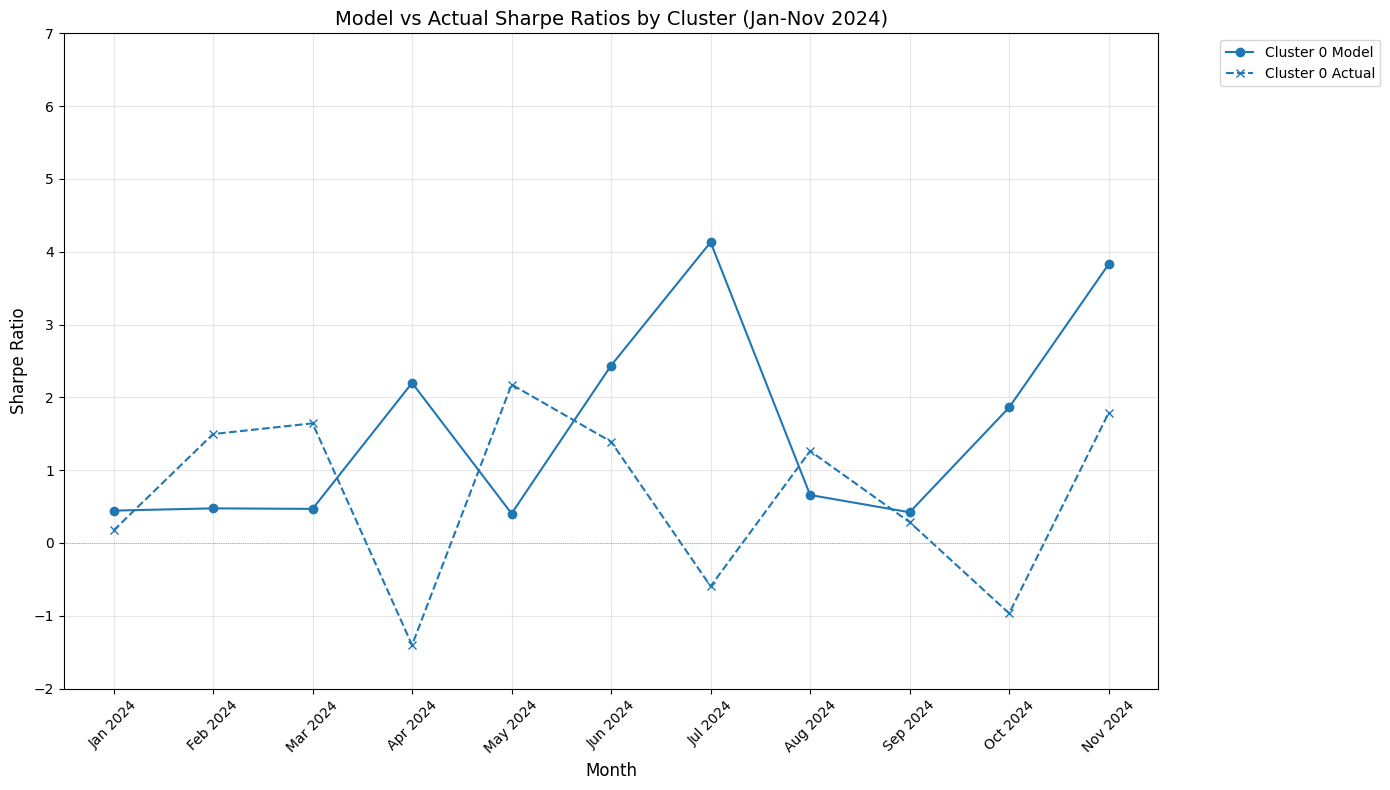

In [1623]:
import matplotlib.pyplot as plt
import pandas as pd

# First ensure Month is in datetime format and sort
final_sharpe_df['Month'] = pd.to_datetime(final_sharpe_df['Month'], format='%b %Y')
final_sharpe_df = final_sharpe_df.sort_values('Month')

# Create month labels for x-axis
month_labels = final_sharpe_df['Month'].dt.strftime('%b %Y').unique()

plt.figure(figsize=(14, 8))

# Define colors and line styles
cluster_colors = {
    0: '#1f77b4',  # Blue
}


cluster_data = final_sharpe_df
    
# Model SR
plt.plot(month_labels,
             cluster_data['Sharpe Ratio'],
             color=cluster_colors[0],
             linestyle='-',
             marker='o',
             label=f'Cluster 0 Model')
    
# Actual SR
plt.plot(month_labels,
             cluster_data['Actual Sharpe Ratio'],
             color=cluster_colors[0],
             linestyle='--',
             marker='x',
             label=f'Cluster 0 Actual')

# Formatting
plt.title('Model vs Actual Sharpe Ratios by Cluster (Jan-Nov 2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Set y-axis limits to focus on relevant range
plt.ylim(-2, 7)

# Add legend and zero line
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=0, color='gray', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()